In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sct
from sklearn import preprocessing
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import tqdm
from sklearn.metrics import mean_squared_error

In [4]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [5]:
df = pd.read_csv("../dataset/inout.csv")

In [6]:
targets=['RES1_BASE', 'RES11_BASE','PRO1_BASE', 'RES2_HC', 'RES2_HP', 'PRO2_HC', 'PRO2_HP']

In [7]:
columns = df.columns
columns

Index(['IDS', 'Horodate_UTC', 'Horodate', 'Mois', 'Injection RTE (W)',
       'Refoulement RTE (W)', 'Pertes modélisées (W)',
       'Consommations totale (W)',
       'Consommation HTA télérelevée à courbe de charge (W)',
       'Consommation totale profilée (W)', 'Consommation HTA profilée (W)',
       'Consommation PME-PMI profilée (W)',
       'Consommation professionnelle profilée (W)',
       'Consommation résidentielle profilée (W)',
       'Production décentralisée totale (W)',
       'Production décentralisée télérelevée à courbe de charge (W)',
       'Production décentralisée profilée (W)',
       'Production photovoltaïque profilée (W)',
       'Production autre profilée (W)',
       'Température réalisée lissée (°Celcius)',
       'Température normale lissée (°Celcius)',
       'Production éolienne totale (W)',
       'Production photovoltaïque totale (W)', 'Pseudo rayonnement',
       'Consommation HTA totale (W)', 'Soutirage net vers autres GRD (W)',
       'RES1_BASE', 

In [8]:
df=df[0:65130]

In [9]:
df_indexed=df.set_index("Horodate_UTC")
df_indexed.index = pd.to_datetime(df.set_index("Horodate_UTC").index)
df_indexed["Year"]=df_indexed.index.year
df_indexed["Month"]=df_indexed.index.month.map(lambda x : np.cos(x*2*np.pi/12))
df_indexed["Day"]=df_indexed.index.day.map(lambda x : np.cos(x*2*np.pi/27))
df_indexed["week_day"]=df_indexed.index.weekday.map(lambda x : np.cos(x*2*np.pi/7))

In [10]:
to_be_predicted = df.columns[-7:]
print(to_be_predicted)

Index(['RES1_BASE', 'RES11_BASE', 'PRO1_BASE', 'RES2_HC', 'RES2_HP', 'PRO2_HC',
       'PRO2_HP'],
      dtype='object')


In [11]:
splitter = TimeSeriesSplit(n_splits=2,test_size=8726)
for train_idx, test_idx in splitter.split(df_indexed):
    df_train, df_test = df_indexed.iloc[:train_idx[-1]],df_indexed.iloc[train_idx[-1]:]

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Arimax model

In [155]:
Xtrain=df_train[to_be_predicted[0]][55000:]
Xtest=df_test[to_be_predicted[0]][0:100]
Xtrain_exo=df_train[['Température réalisée lissée (°Celcius)', 'Production éolienne totale (W)']][55000:]
Xtest_exo= df_test[['Température réalisée lissée (°Celcius)', 'Production éolienne totale (W)']][0:100]

In [156]:
print(df_train[to_be_predicted[0]].tail(20))

Horodate_UTC
2016-12-31 13:30:00    1.665115
2016-12-31 14:00:00    1.618493
2016-12-31 14:30:00    1.613714
2016-12-31 15:00:00    1.597147
2016-12-31 15:30:00    1.722038
2016-12-31 16:00:00    1.858824
2016-12-31 16:30:00    1.991362
2016-12-31 17:00:00    2.053171
2016-12-31 17:30:00    2.082694
2016-12-31 18:00:00    2.051365
2016-12-31 18:30:00    1.989451
2016-12-31 19:00:00    1.871143
2016-12-31 19:30:00    1.831106
2016-12-31 20:00:00    1.700692
2016-12-31 20:30:00    1.611590
2016-12-31 21:00:00    1.561569
2016-12-31 21:30:00    1.482238
2016-12-31 22:00:00    1.419049
2016-12-31 22:30:00    1.305414
2016-12-31 23:00:00    1.232879
Name: RES1_BASE, dtype: float64


In [22]:
def split_df_to_train(df_train,df_test,k1,data_to_predict,list_exo):
    '''
    df_train: données d'entraineme
    df_test : données à tester 
    k1: nombre de points avant j pour prédire 
    data_to_predict : name of the data to predict 
    list_exo : list of name of the exeogenous parameters 
    
    '''

    Xtrain=df_train[data_to_predict].tail(k1)
    Xtest=df_test[data_to_predict]
    Xtrain_exo=df_train[list_exo].tail(k1)
    Xtest_exo= df_test[list_exo]

    return Xtrain,Xtest,Xtrain_exo,Xtest_exo

    

In [85]:
exo=['Température réalisée lissée (°Celcius)', 'Production éolienne totale (W)']
Xtrain,Xtest,Xtrain_exo,Xtest_exo=split_df_to_train(df_train=df_train,df_test=df_test,k1=5000,data_to_predict="RES1_BASE",list_exo=exo)
print(Xtest.head(2))

print(Xtrain_exo.columns)

Horodate_UTC
2016-12-31 23:30:00    1.134963
2017-01-01 00:00:00    1.068481
Name: RES1_BASE, dtype: float64
Index(['Température réalisée lissée (°Celcius)', 'Production éolienne totale (W)'], dtype='object')


In [86]:
def evaluate_arimax_model(X_train, X_test, arima_order, exogenous_var_train, exogenous_var_test):
    k1=len(Xtrain) ## k1 is the number of points we consider for the train ()
    mycolonne=exogenous_var_train.columns 
    history = [x for x in X_train] ## history of Xvalues we use for predictions , we use the last k1 values 
    exog=np.array([[x for x in exogenous_var_train[elt]] for elt in exogenous_var_train.columns]).T.tolist()
    exog_test=np.array([[x for x in exogenous_var_test[elt]] for elt in exogenous_var_test.columns]).T.tolist()
    # make predictions
    predictions = list()
    L_error=list()
    for t,_ in enumerate(tqdm.tqdm(np.arange(0,len(Xtest)//96+1))):
        if t*96+96<len(Xtest):
            model = SARIMAX(endog=history[-k1:], order=arima_order, exog=exog[-k1:],enforce_stationarity=True)
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast(steps=96,exog=exog_test[t*96:t*96+96])
            predictions.extend(yhat.tolist())
            history.extend(Xtest.values[t*96:t*96+96])
            exog.extend(exog_test[t*96:t*96+t])
            L_error.append(rmse(Xtest.values[t*96:t*96+96],yhat))
        else:
            return L_error,predictions


    #error = rmse(X_test, predictions)

    #return error, predictions


In [87]:
order=(1,1,2)
error,predictions=evaluate_arimax_model(Xtrain,Xtest,order,Xtrain_exo,Xtest_exo)

 99%|█████████▉| 90/91 [01:27<00:00,  1.02it/s]


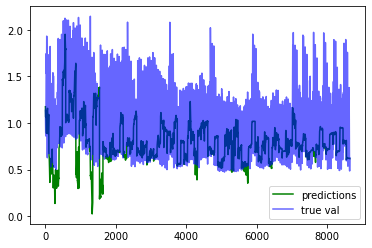

In [88]:
longueur=len(predictions)
#print(longueur)
Lx=np.arange(0,longueur)
toprint=Xtest[0:8640]
#print(toprint)
plt.figure()
plt.plot(Lx,predictions,label='predictions',color='g')
#plt.show()
plt.plot(Lx,toprint,label="true val",color='b',alpha=0.6)
plt.legend()
plt.show()

In [89]:
print("RMSE = ", np.mean(error))

RMSE =  0.40093576940342596


In [164]:

def arimax_grid_search(X_train, X_test, p_values, d_values, q_values, exogenous_var_train, exogenous_var_test):
    

    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse, _ = evaluate_arimax_model(
                        X_train, X_test, order, exogenous_var_train, exogenous_var_test)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print("ARIMAX(%d,%d,%d) RMSE=%.3f Exogenous =" %
                          (p, d, q, rmse))

                except:
                    continue

    print("Best ARIMAX%s MSE=%.3f" % (best_cfg, best_score))

    return best_cfg, best_score

## Sarimax model 

In [23]:
def evaluate_sarimax_model(X_train, X_test, arima_order,seasonal_order ,exogenous_var_train, exogenous_var_test):
    k1=len(Xtrain) ## k1 is the number of points we consider for the train ()
    mycolonne=exogenous_var_train.columns 
    history = [x for x in X_train] ## history of Xvalues we use for predictions , we use the last k1 values 
    exog=np.array([[x for x in exogenous_var_train[elt]] for elt in exogenous_var_train.columns]).T.tolist()
    exog_test=np.array([[x for x in exogenous_var_test[elt]] for elt in exogenous_var_test.columns]).T.tolist()
    # make predictions
    predictions = list()
    L_error=list()
    for t,_ in enumerate(tqdm.tqdm(np.arange(0,len(Xtest)//96+1))):
        if t*96+96<len(Xtest):
            model = SARIMAX(endog=history[-k1:], order=arima_order,seasonal_order=seasonal_order, exog=exog[-k1:],enforce_stationarity=True)
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast(steps=96,exog=exog_test[t*96:t*96+96])
            predictions.extend(yhat.tolist())
            history.extend(Xtest.values[t*96:t*96+96])
            exog.extend(exog_test[t*96:t*96+t])
            L_error.append(rmse(Xtest.values[t*96:t*96+96],yhat))
        else:
            return L_error,predictions


In [68]:
exo=['Température réalisée lissée (°Celcius)', 'Production éolienne totale (W)']
Xtrain,Xtest,Xtrain_exo,Xtest_exo=split_df_to_train(df_train=df_train,df_test=df_test,k1=3000,data_to_predict="RES1_BASE",list_exo=exo)
print(Xtest.head(2))

print(Xtrain_exo.columns)

Horodate_UTC
2016-12-31 23:30:00    1.134963
2017-01-01 00:00:00    1.068481
Name: RES1_BASE, dtype: float64
Index(['Température réalisée lissée (°Celcius)', 'Production éolienne totale (W)'], dtype='object')


In [77]:
s=4
order=(1,1,1) # p,d,q pour la trend 
seasonal_order=(0,0,1)+(s,)   #P,D,Q,s pour la saisonnalité
error,predictions=evaluate_sarimax_model(Xtrain,Xtest,order,seasonal_order,Xtrain_exo,Xtest_exo)

 99%|█████████▉| 90/91 [01:08<00:00,  1.31it/s]


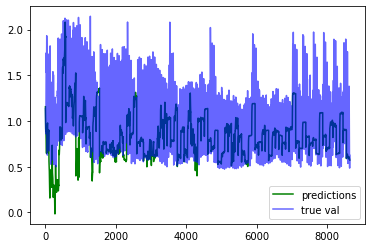

In [78]:
longueur=len(predictions)
#print(longueur)
Lx=np.arange(0,longueur)
toprint=Xtest[0:8640]
#print(toprint)
plt.figure()
plt.plot(Lx,predictions,label='predictions',color='g')
#plt.show()
plt.plot(Lx,toprint,label="true val",color='b',alpha=0.6)
plt.legend()
plt.show()

In [79]:
print("RMSE = ", np.mean(error))

RMSE =  0.3917510251764217


In [60]:
Xtest.to_frame()


,RES1_BASE
Horodate_UTC,
2016-12-31 23:30:00,1.134963
2017-01-01 00:00:00,1.068481
2017-01-01 00:30:00,1.045011
2017-01-01 01:00:00,1.010284
2017-01-01 01:30:00,0.977149
...,...
2017-01-07 16:30:00,0.818061
2017-01-07 17:00:00,0.738198
2017-01-07 17:30:00,0.662796


In [63]:
data=Xtest.head(5)
data.asfreq(freq='10S')
data.index

DatetimeIndex(['2016-12-31 23:30:00', '2017-01-01 00:00:00',
               '2017-01-01 00:30:00', '2017-01-01 01:00:00',
               '2017-01-01 01:30:00'],
              dtype='datetime64[ns]', name='Horodate_UTC', freq=None)

In [64]:
Xtest=Xtest.asfreq(freq="30min")
Xtest

Horodate_UTC
2016-12-31 23:30:00    1.134963
2017-01-01 00:00:00    1.068481
2017-01-01 00:30:00    1.045011
2017-01-01 01:00:00    1.010284
2017-01-01 01:30:00    0.977149
                         ...   
2017-01-07 16:30:00    0.818061
2017-01-07 17:00:00    0.738198
2017-01-07 17:30:00    0.662796
2017-01-07 18:00:00    0.609696
2017-01-07 18:30:00    0.583146
Freq: 30T, Name: RES1_BASE, Length: 327, dtype: float64

In [67]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Xtest, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.841700154753768
2. P-Value :  4.522945420455233e-05
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 324
5. Critical Values :
	 1% :  -3.450695263332383
	 5% :  -2.87050218926466
	 10% :  -2.5715449066453284


In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(Xtest, model="additive")
decompose_data.plot();

ValueError: freq T not understood. Please report if you think this is in error.